# NCAA 2025 Prediction Simulation 


# SYSTEM ARCHITECTURE
## 1. Data Ingestion

In this first phase, we load all relevant datasets from Kaggle, including:
- Regular season results
- Tournament results
- Team seeds
- Team metadata

We will filter the data for seasons from 2015 onward, and extract key values such as the numeric part of each team's seed.

In [ ]:
# Load datasets
import pandas as pd
import re

DATA_PATH = "Data/"

regular_season = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
teams = pd.read_csv(DATA_PATH + "MTeams.csv")
seasons = pd.read_csv(DATA_PATH + "MSeasons.csv")
submission = pd.read_csv(DATA_PATH + "SampleSubmissionStage1.csv")

# Quick sanity checks
print(" Regular season shape:", regular_season.shape)
print(" Tournament results shape:", tourney_results.shape)
print(" Seeds example:\n", seeds.head())
print(" Teams loaded:", len(teams))

 Regular season shape: (118882, 34)
 Tournament results shape: (2518, 8)
 Seeds example:
    Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374
 Teams loaded: 380


## 2. Data Reprocessing
### Filter datasets to include only seasons from 2015 onward

We restrict the analysis to data from 2015 and later to ensure consistency and relevance. This filter is applied to the regular season games, tournament results, and seed information.


In [10]:
# Filter data for seasons from 2015 onward and verify

# Regular Season
print("Regular Season (before):", regular_season.shape)
print("Seasons (before):", sorted(regular_season["Season"].unique()))

regular_season = regular_season[regular_season["Season"] >= 2015]

print("Regular Season (after):", regular_season.shape)
print("Seasons (after):", sorted(regular_season["Season"].unique()))

# Tournament Results
print("\nTournament Results (before):", tourney_results.shape)
print("Seasons (before):", sorted(tourney_results["Season"].unique()))

tourney_results = tourney_results[tourney_results["Season"] >= 2015]

print("Tournament Results (after):", tourney_results.shape)
print("Seasons (after):", sorted(tourney_results["Season"].unique()))

# Seeds
print("\nSeeds (before):", seeds.shape)
print("Seasons (before):", sorted(seeds["Season"].unique()))

seeds = seeds[seeds["Season"] >= 2015]

print("Seeds (after):", seeds.shape)
print("Seasons (after):", sorted(seeds["Season"].unique()))


Regular Season (before): (118882, 34)
Seasons (before): [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Regular Season (after): (58364, 34)
Seasons (after): [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Tournament Results (before): (2518, 8)
Seasons (before): [np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002)

### Process team seeds and extract numeric values

Each team in the NCAA tournament is assigned a "seed" (e.g., 'W05', 'X12b') representing its rank within a region.
To use this as a numeric feature, we extract only the numeric part of the seed (e.g., 'W05' → 5).

This will later allow us to compute the seed difference between two teams.


In [11]:
import re

# Function to extract the numeric seed from strings like 'W05', 'X12b', etc.
def extract_seed_number(seed_str):
    match = re.search(r'\d+', seed_str)
    return int(match.group()) if match else None

# Apply to the seed column
seeds["SeedNum"] = seeds["Seed"].apply(extract_seed_number)

# Preview results
print(seeds[["Season", "TeamID", "Seed", "SeedNum"]].head(10))


      Season  TeamID Seed  SeedNum
1946    2015    1437  W01        1
1947    2015    1438  W02        2
1948    2015    1328  W03        3
1949    2015    1257  W04        4
1950    2015    1320  W05        5
1951    2015    1344  W06        6
1952    2015    1277  W07        7
1953    2015    1301  W08        8
1954    2015    1261  W09        9
1955    2015    1208  W10       10


## 3. Feature Engineering
### Compute seed difference for each tournament game

We now join the seed values to both teams in each game from the NCAA tournament historical results.

The seed difference (SeedB - SeedA) will be one of the key features used for prediction.


In [35]:
# Rename seed dataframe to merge easily
seeds_A = seeds.rename(columns={"TeamID": "WTeamID", "SeedNum": "SeedA"})  # Winner
seeds_B = seeds.rename(columns={"TeamID": "LTeamID", "SeedNum": "SeedB"})  # Loser

# Merge seed values to tournament results
tourney_seeds = pd.merge(tourney_results, seeds_A[["Season", "WTeamID", "SeedA"]], on=["Season", "WTeamID"], how="left")

tourney_seeds = pd.merge(tourney_seeds, seeds_B[["Season", "LTeamID", "SeedB"]], on=["Season", "LTeamID"], how="left")

# Calculate seed difference (Team B - Team A)
tourney_seeds["SeedDiff"] = tourney_seeds["SeedB"] - tourney_seeds["SeedA"]

# Preview result
tourney_seeds[["Season", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"]].head()



,Season,WTeamID,LTeamID,SeedA,SeedB,SeedDiff
0,2015,1214,1264,16,16,0
1,2015,1279,1140,11,11,0
2,2015,1173,1129,11,11,0
3,2015,1352,1316,16,16,0
4,2015,1112,1411,2,15,13


In [36]:
# Rename seed dataframe to merge easily
seeds_A = seeds.rename(columns={"TeamID": "WTeamID", "SeedNum": "SeedA"})  # Winner
seeds_B = seeds.rename(columns={"TeamID": "LTeamID", "SeedNum": "SeedB"})  # Loser

# Merge seed values to tournament results
tourney_seeds = pd.merge(tourney_results, seeds_A[["Season", "WTeamID", "SeedA"]], on=["Season", "WTeamID"], how="left")

tourney_seeds = pd.merge(tourney_seeds, seeds_B[["Season", "LTeamID", "SeedB"]], on=["Season", "LTeamID"], how="left")

# Calculate seed difference (Team B - Team A)
tourney_seeds["SeedDiff"] = tourney_seeds["SeedB"] - tourney_seeds["SeedA"]

# Preview result
tourney_seeds[["Season", "WTeamID", "LTeamID", "SeedA", "SeedB", "SeedDiff"]].head()

# Load regular season detailed results
reg_season = pd.read_csv("Data/MRegularSeasonDetailedResults.csv")
reg_season = reg_season[reg_season["Season"] >= 2015]

# Stats for winning team
w_stats = reg_season[["Season", "WTeamID", "WScore", "LScore"]].copy()
w_stats["Win"] = 1
w_stats.rename(columns={
    "WTeamID": "TeamID",
    "WScore": "PointsScored",
    "LScore": "PointsAllowed"
}, inplace=True)

# Stats for losing team
l_stats = reg_season[["Season", "LTeamID", "LScore", "WScore"]].copy()
l_stats["Win"] = 0
l_stats.rename(columns={
    "LTeamID": "TeamID",
    "LScore": "PointsScored",
    "WScore": "PointsAllowed"
}, inplace=True)

# Combine and aggregate
all_stats = pd.concat([w_stats, l_stats], ignore_index=True)

team_stats = all_stats.groupby(["Season", "TeamID"]).agg(
    GamesPlayed=("Win", "count"),
    Wins=("Win", "sum"),
    AvgPointsScored=("PointsScored", "mean"),
    AvgPointsAllowed=("PointsAllowed", "mean"),
    TotalPointsScored=("PointsScored", "sum"),
    TotalPointsAllowed=("PointsAllowed", "sum")
).reset_index()

team_stats["WinLossRatio"] = team_stats["Wins"] / team_stats["GamesPlayed"]
team_stats["ScoringMargin"] = team_stats["AvgPointsScored"] - team_stats["AvgPointsAllowed"]

# Preview
team_stats.head()


,Season,TeamID,GamesPlayed,Wins,AvgPointsScored,AvgPointsAllowed,TotalPointsScored,TotalPointsAllowed,WinLossRatio,ScoringMargin
0,2015,1101,28,7,61.000000,71.857143,1708,2012,0.250000,-10.857143
1,2015,1102,29,12,64.724138,65.862069,1877,1910,0.413793,-1.137931
2,2015,1103,34,20,67.352941,63.235294,2290,2150,0.588235,4.117647
3,2015,1104,31,17,66.645161,64.516129,2066,2000,0.548387,2.129032
4,2015,1105,28,8,61.285714,68.714286,1716,1924,0.285714,-7.428571


### Create a neutral matchup dataset for training

To train a predictive model, we restructure each historical game into a matchup between TeamA and TeamB, and assign a binary target variable `Winner`.

For balance, each game is represented twice:
- Once with the winning team as TeamA (`Winner = 1`)
- Once with the losing team as TeamA (`Winner = 0`)


In [15]:
# First version: winner is TeamA
df_win = tourney_seeds.copy()
df_win["TeamA"] = df_win["WTeamID"]
df_win["TeamB"] = df_win["LTeamID"]
df_win["SeedDiff"] = df_win["SeedB"] - df_win["SeedA"]
df_win["Winner"] = 1

# Second version: loser is TeamA
df_lose = tourney_seeds.copy()
df_lose["TeamA"] = df_lose["LTeamID"]
df_lose["TeamB"] = df_lose["WTeamID"]
df_lose["SeedDiff"] = df_lose["SeedA"] - df_lose["SeedB"]
df_lose["Winner"] = 0

# Combine both
matchups = pd.concat([df_win, df_lose], ignore_index=True)

# Keep only necessary columns
matchups = matchups[["Season", "TeamA", "TeamB", "SeedDiff", "Winner"]]

# Preview
matchups.sample(5)


,Season,TeamA,TeamB,SeedDiff,Winner
65,2015,1458,1246,0,1
902,2019,1433,1416,1,0
509,2023,1397,1181,1,1
242,2018,1276,1222,3,1
1022,2022,1103,1417,-9,0


## 4. Prediction Engine
### Train a prediction model (Logistic Regression)

We will now train a logistic regression model using historical NCAA tournament games. The model will learn to estimate the probability that TeamA wins based on the seed difference.


In [18]:
#!pip install scikit-learn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Select features and target
X = matchups[["SeedDiff"]]   # Feature(s)
y = matchups["Winner"]       # Target (1 if TeamA won, 0 otherwise)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.6390041493775933
AUC Score: 0.6642561983471075


## Simulation Experiments
### Baseline Scenario

In this experiment, we apply the trained logistic regression model to all possible team matchups in the NCAA 2025 tournament. For each unique combination of TeamA vs TeamB, we compute the seed difference and use it to estimate the probability that TeamA wins. This baseline prediction scenario represents the system's output under ideal, unaltered input conditions.


In [25]:
from itertools import combinations
import numpy as np

# Step 1: Filter seeds for the 2025 tournament
seeds_2025 = seeds[seeds["Season"] == 2025][["TeamID", "SeedNum"]].copy()

# Step 2: Generate all possible pairwise matchups (TeamA vs TeamB, A ≠ B)
matchups_2025 = []

for teamA, teamB in combinations(seeds_2025["TeamID"], 2):
    seedA = seeds_2025.loc[seeds_2025["TeamID"] == teamA, "SeedNum"].values[0]
    seedB = seeds_2025.loc[seeds_2025["TeamID"] == teamB, "SeedNum"].values[0]
    
    # First version: TeamA vs TeamB
    matchups_2025.append({
        "TeamA": teamA,
        "TeamB": teamB,
        "SeedDiff": seedB - seedA
    })
    
    # Second version: TeamB vs TeamA (mirror)
    matchups_2025.append({
        "TeamA": teamB,
        "TeamB": teamA,
        "SeedDiff": seedA - seedB
    })

# Step 3: Convert to DataFrame
matchups_2025_df = pd.DataFrame(matchups_2025)

# Step 4: Predict win probabilities
matchups_2025_df["Pred"] = model.predict_proba(matchups_2025_df[["SeedDiff"]])[:, 1]

# Save baseline predictions to the Data folder
matchups_2025_df.to_csv("Data/baseline_predictions_2025.csv", index=False)

# Preview
matchups_2025_df.head()


,TeamA,TeamB,SeedDiff,Pred
0,1181,1104,1,0.537314
1,1104,1181,-1,0.456373
2,1181,1458,2,0.577319
3,1458,1181,-2,0.416490
4,1181,1112,3,0.616335


### Peturber Scenario

To simulate data uncertainty or measurement errors, we introduce random noise into the input feature `SeedDiff` from the 2025 tournament matchups.

The perturbation is a random value between ±2% and ±5% of the original seed difference. We then reapply the trained model to these noisy inputs to observe how sensitive the system is to small variations.


In [26]:
import numpy as np

# Make a copy of the baseline predictions
perturbed_df = matchups_2025_df.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Generate random perturbation between ±2% and ±5% of abs(SeedDiff)
perturbation_pct = np.random.uniform(0.02, 0.05, size=len(perturbed_df))
perturbation_sign = np.random.choice([-1, 1], size=len(perturbed_df))
perturbation = perturbation_pct * perturbed_df["SeedDiff"].abs() * perturbation_sign

# Create a new column with perturbed values (for reference)
perturbed_df["PerturbedSeedDiff"] = perturbed_df["SeedDiff"] + perturbation

# Overwrite SeedDiff with perturbed values to match model input expectations
perturbed_df["SeedDiff"] = perturbed_df["PerturbedSeedDiff"]

# Predict using the trained model
perturbed_df["PerturbedPred"] = model.predict_proba(
    perturbed_df[["SeedDiff"]]
)[:, 1]

# Save perturbed prediction to Data folder
perturbed_df.to_csv("Data/perturbed_predictions_2025.csv", index=False)

# Preview result
perturbed_df[["TeamA", "TeamB", "PerturbedSeedDiff", "Pred", "PerturbedPred"]].head()


,TeamA,TeamB,PerturbedSeedDiff,Pred,PerturbedPred
0,1181,1104,1.031236,0.537314,0.538574
1,1104,1181,-1.048521,0.456373,0.454420
2,1181,1458,2.083920,0.577319,0.580638
3,1458,1181,-2.075920,0.416490,0.413500
4,1181,1112,2.925958,0.616335,0.613491


Average change in prediction: 0.0051
Matchups with >±0.10 change: 0.00%


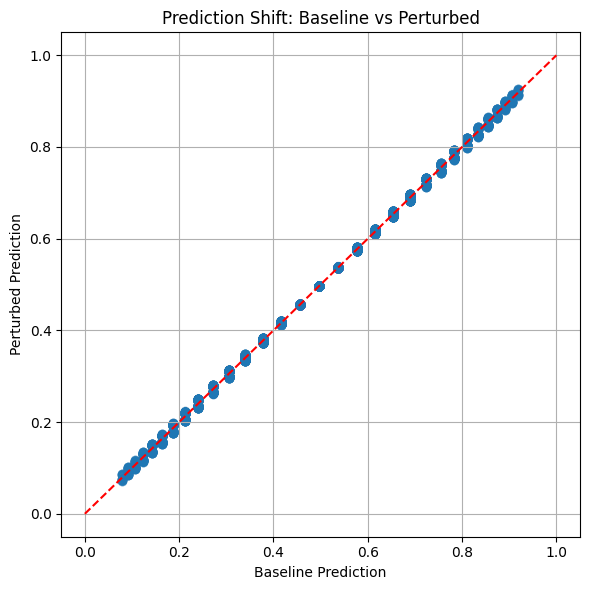

In [30]:
#!pip install matplotlib

import matplotlib.pyplot as plt

# Merge baseline and perturbed predictions
comparison_df = matchups_2025_df[["TeamA", "TeamB", "Pred"]].copy()
comparison_df["PerturbedPred"] = perturbed_df["PerturbedPred"]

# Calculate absolute difference
comparison_df["Delta"] = comparison_df["PerturbedPred"] - comparison_df["Pred"]
comparison_df["AbsDelta"] = comparison_df["Delta"].abs()

# Metrics
avg_change = comparison_df["AbsDelta"].mean()
shift_pct = (comparison_df["AbsDelta"] > 0.10).mean() * 100

print(f"Average change in prediction: {avg_change:.4f}")
print(f"Matchups with >±0.10 change: {shift_pct:.2f}%")

# Simple scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(comparison_df["Pred"], comparison_df["PerturbedPred"], alpha=0.3)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # identity line
plt.xlabel("Baseline Prediction")
plt.ylabel("Perturbed Prediction")
plt.title("Prediction Shift: Baseline vs Perturbed")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
matchups_2025_df["Pred"].describe()

count    4556.000000
mean        0.497465
std         0.224899
min         0.079704
25%         0.304930
50%         0.496823
75%         0.689656
max         0.918411
Name: Pred, dtype: float64